# Draft 1 - Figure 3

_Description of our goal:_  

Summary statistics for select regions over both obs. unc. products and all 4 GCMs + 1 OBS-LE

### Load functions and packages

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask, gridspec
    )

from functions import to_png

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from matplotlib.patches import Rectangle

def axis_breaky(axis, ypos=[0.1, 0.125], xpos=0,slant=1.5,w=0.1,zorder=3):
    d = slant  # proportion of vertical to horizontal extent of the slanted line
    anchor = (xpos,ypos[0])
    h = ypos[1] - ypos[0]

    kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12, zorder=zorder,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axis.add_patch(Rectangle(
        anchor, width=w, height=h, fill=True, color="white",
        transform=axis.transAxes, clip_on=False, zorder=zorder)
    )
    axis.plot([0, 0], ypos, transform=axis.transAxes, **kwargs)

In [3]:
def compute_tte(obs_trends,pic_trends):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    _tte_bool = obs_trends > pic_trends
    _tte      = 1960 + _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte!=1960+obs_trends.duration.max(),np.nan) # Mask the unemerged regions
    _tte      = _tte.drop(['percentile'])
    
    return _tte

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [4]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [5]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

In [6]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [7]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)

In [8]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath)

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath)

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath)

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath)

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [9]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/'
hadcrut5_dir    = 'HadCRUT5/'
obsle_dir       = 'mckinnon_OLENS/'

In [10]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'
obsle_tas_var    = 'tas'

In [11]:
gistemp_5x5_spatial_trends_filepath  = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.??????-??????.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [12]:
gistemp_5x5_regional_trends_filepath  = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_regional_trends_filepath     = glob.glob('%s/%s/*trends.196001-202012*.nc' % (obs_tseries_dir,hadcrut5_dir))
obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

Load the trend data

In [13]:
gistemp_5x5_spatial_trends_all  = xr.open_mfdataset(gistemp_5x5_spatial_trends_filepath).drop('startyear')['tas'].chunk({'record': -1})
hadcrut5_spatial_trends_all     = xr.open_mfdataset(hadcrut5_spatial_trends_filepath).drop('startyear').rename({'longitude':'lon','latitude':'lat','realization':'record'})['tas'].chunk({'record': -1})
gistemp_5x5_spatial_trends_all['record'] = gistemp_5x5_spatial_trends_all['record'] - 2 # Shift back to 1
obsle_spatial_trends_all        = xr.open_dataarray(*obsle_spatial_trends_filepath)

In [14]:
gistemp_5x5_regional_trends_all  = xr.open_dataarray(*gistemp_5x5_regional_trends_filepath).sel(startyear=1960).drop('startyear')
hadcrut5_regional_trends_all     = xr.open_dataarray(*hadcrut5_regional_trends_filepath).sel(startyear=1960).drop('startyear').rename({'realization':'record'})
obsle_regional_trends_all        = xr.open_dataarray(*obsle_regional_trends_filepath)

Load obs-le percentile data

### Compute TTE generally

In [15]:
obs_spatial_trend_dict  = {'GISTEMP_5x5':gistemp_5x5_spatial_trends_all,
                           'HadCRUT':hadcrut5_spatial_trends_all}
obs_regional_trend_dict = {'GISTEMP_5x5':gistemp_5x5_regional_trends_all,
                           'HadCRUT':hadcrut5_regional_trends_all}
obs_trend_dict          = {'spatial':obs_spatial_trend_dict,
                           'regional':obs_regional_trend_dict}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                            'OBS-LE':obsle_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                             'OBS-LE':obsle_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute the TTE for each ensemble member separately.

In [16]:
%%time 

spatial_box = []
regional_box = []

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte(obs_trends=_obs_trends.median(dim='record'),
                                    pic_trends=_model_trends.sel(percentile=97.5))

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte(obs_trends=_obs_trends,
                                      pic_trends=_model_trends.sel(percentile=97.5))

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95,dim='record',interpolation='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region,2020 - _mean_toe,_delay_toe) # Apply the conditional mask

            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box,dim='obs').compute())
    
spatial_masked_da = spatial_box[0]

spatial
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


regional
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
OBS-LE
HadCRUT
CESM1
MPI
CanESM2
ESM2M
OBS-LE
CPU times: user 7.59 s, sys: 1.28 s, total: 8.88 s
Wall time: 9.56 s


### Figure 3

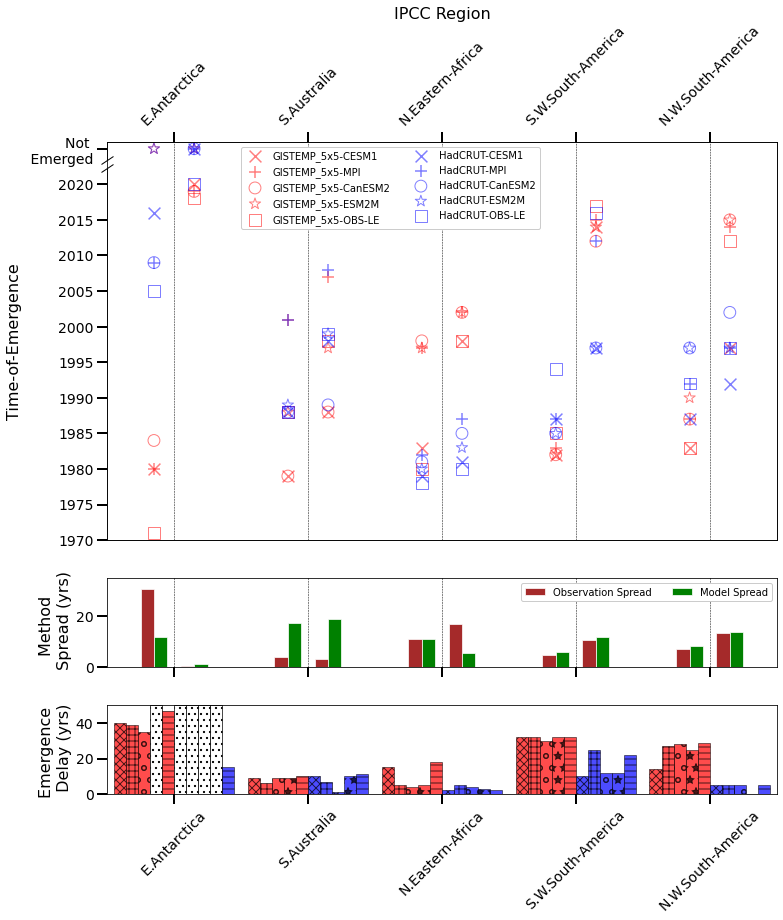

In [17]:
symbols = ['x','+','o','*','s']
hatches = ['xxx','++','o','*','--']
colors  = ['red','blue']
nan_hatch = '..' #'xx'

final_tte_ds = regional_box[0]

# Symbols that need a fill color
fill_symbols = ['x','+',]
s_value = 140

fig = plt.figure(figsize=(12,12))

gs = gridspec.GridSpec(3,1,height_ratios=[9,2,2],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1b = ax1.twiny()

region_indices = [44,42,23,13,9]
startyear = 1970

final_tte_subset = final_tte_ds.sel(RegionIndex=region_indices)

tick_labels = []

xstats = []
for i,_index in enumerate(final_tte_subset.RegionIndex):
    xstat = i
    xstats.append(xstat)
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _mean_subset = _region_subset.sel(metric='mean')
    _strict_subset = _region_subset.sel(metric='strict')
    
    _mean_obs_spread = (_mean_subset.max(dim='obs') - _mean_subset.min(dim='obs')).mean(dim='model')#,skipna=False)
    _mean_mod_spread = (_mean_subset.max(dim='model') - _mean_subset.min(dim='model')).mean(dim='obs')
    
    _strict_obs_spread = (_strict_subset.max(dim='obs') - _strict_subset.min(dim='obs')).mean(dim='model')#,skipna=False)
    _strict_mod_spread = (_strict_subset.max(dim='model') - _strict_subset.min(dim='model')).mean(dim='obs')
    
    _delay_avg = (_strict_subset - _mean_subset).mean(dim=['obs','model'])
    _delay = _strict_subset - _mean_subset   

    ax2.bar(xstat-0.2, _mean_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
    ax2.bar(xstat-0.1, _mean_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
    ax2.bar(xstat+0.1, _strict_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)#, hatch='//')
    ax2.bar(xstat+0.2, _strict_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)#, hatch='//')
    
    # Look to hide nans
    if np.isnan(_mean_obs_spread):
        ax2.bar(xstat-0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_mean_mod_spread):
        ax2.bar(xstat-0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_strict_obs_spread):
        ax2.bar(xstat+0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_strict_mod_spread):
        ax2.bar(xstat+0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    
    # These should adapt to the number of models used to estimate PIC conditions
    space_factor = 0.9 # parameter setting the blank space between IPCC regions
    ax3_width = space_factor / (2*len(symbols))
    _offset = (0.5 - len(symbols)) * ax3_width
    
    for _obs,_color in zip(_mean_subset.obs,colors):

        _obs_subset = _mean_subset.sel(obs=_obs)

        for _model,_symbol,_hatch in zip(_obs_subset.model,symbols,hatches):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
            if (_symbol in fill_symbols):
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                
            if (np.isnan(_delay.sel(obs=_obs,model=_model))):
                ax3.bar(xstat+_offset, 50, 
                        width=ax3_width, color='white',edgecolor="black",
                        hatch=nan_hatch,linewidth=0.7)
            else:
                ax3.bar(xstat+_offset,_delay.sel(obs=_obs,model=_model),
                        width=ax3_width,color=_color,alpha=0.7,edgecolor="black",
                        hatch=_hatch,linewidth=0.7)
            
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                    
            _offset += ax3_width

    for _obs,_color in zip(_strict_subset.obs,colors):

        _obs_subset = _strict_subset.sel(obs=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            if (_symbol in fill_symbols):
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
        
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)                

# Prep legend with fake plots.
for _obs,_color in zip(_strict_subset.obs,colors):

    _obs_subset = _strict_subset.sel(obs=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        obs_str   = str(_obs.values)
        model_str = str(_model.values)
        if (_symbol in fill_symbols):
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors=_color,edgecolors=_color)
        else:
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors='none',edgecolors=_color)
        
ax2.bar(0,0, width=0.1, color='brown', edgecolor="white", linewidth=0.7, label='Observation Spread')
ax2.bar(0,0, width=0.1, color='green', edgecolor="white", linewidth=0.7, label='Model Spread')
# ax2.bar(0,0, width=0.5, color='gray',  edgecolor="black", linewidth=0.7, alpha=0.3, label='Average Delay')
        
# ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
ax1.vlines(xstats,ymin=startyear,ymax=2026,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)
ax2.vlines(xstats,ymin=0,ymax=45,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)

# Lower panel settings
# ax1.set_xlabel('IPCC Region',fontsize=16)
ax1.set_ylabel('Time-of-Emergence',fontsize=16)
ax1.set_xticks(np.arange(1,5+1))
ax1.set_xticklabels(['' for i in range(5)],fontsize=14,rotation=45)
ax1.set_yticks(np.arange(startyear,2026,5))
ax1.set_yticklabels([str(startyear+5*i) for i in range(len(ax1.get_yticks())-1)]+['Not \n Emerged'])
ax1.set_xlim(-0.5,4.5)
ax1.set_ylim(startyear,2026)
ax1.tick_params(axis='x',labelsize=14,length=0,width=0)
ax1.tick_params(axis='y',labelsize=14,length=10,width=2)

ax1b.set_xticks(np.arange(0,5))
ax1b.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax1b.set_xlim(-0.5,4.5)
ax1b.tick_params(axis='both',labelsize=14,length=10,width=2)
ax1b.set_xlabel('IPCC Region',fontsize=16)

# Upper panel settings
ax2.set_ylabel('Method \n Spread (yrs)',fontsize=16)
ax2.set_xticks(np.arange(0,5))
ax2.set_xticklabels(['' for i in range(5)],fontsize=14,rotation=45)
ax2.set_xlim(-0.5,4.5)
ax2.set_ylim(0,35)
ax2.tick_params(axis='both',labelsize=14,length=10,width=2)

# Delay panel settings
ax3.set_ylabel('Emergence \n Delay (yrs)',fontsize=16)
ax3.set_xticks(np.arange(0,5))
# ax3.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax3.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax3.set_xlim(-0.5,4.5)
ax3.set_ylim(0,50)
ax3.tick_params(axis='both',labelsize=14,length=10,width=2)

# Axis breaks. I think it can't draw over the plot border because of gridspec
axis_breaky(ax1, ypos=[0.935,0.955], slant=1.5,xpos=0.0,zorder=50,w=0.01)

ax1.legend(ncol=2,loc=[0.2,0.78],fontsize=10,facecolor='white', framealpha=1)
ax2.legend(ncol=2,loc='best',fontsize=10,facecolor='white', framealpha=1)

In [18]:
to_png(file=fig,filename='TOE_comparison2_IPCCregions_coneplots',dpi=300,ext='pdf',bbox_inches='tight')

### Supplemental Figures

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator


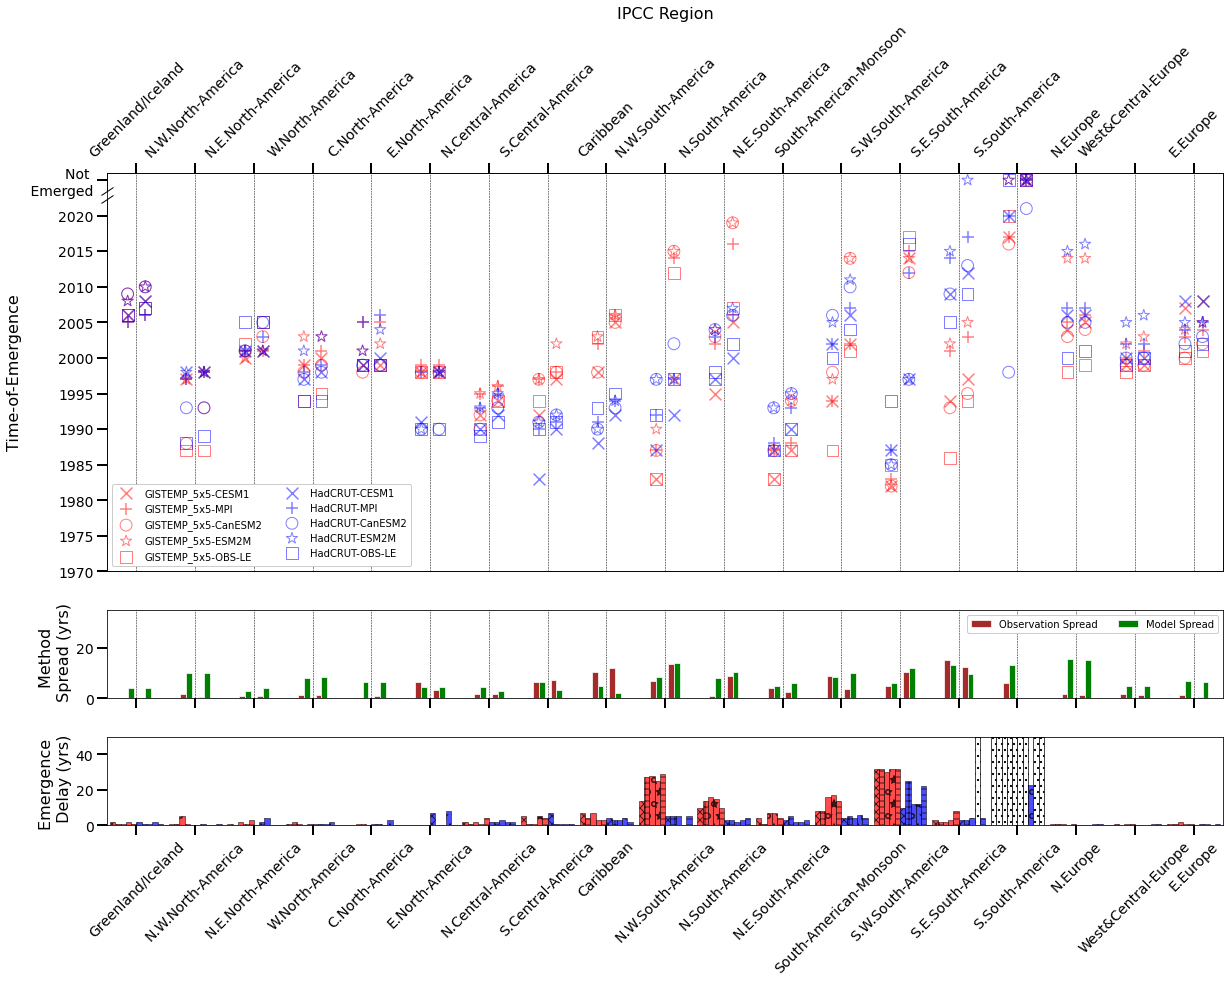

In [19]:
symbols = ['x','+','o','*','s']
hatches = ['xxx','++','o','*','--']
colors  = ['red','blue']
nan_hatch = '..' #'xx'

final_tte_ds = regional_box[0]

# Symbols that need a fill color
fill_symbols = ['x','+',]
s_value = 140
startyear = 1970

fig = plt.figure(figsize=(20,12))

gs = gridspec.GridSpec(3,1,height_ratios=[9,2,2],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1b = ax1.twiny()

start_idx = 0
stop_idx  = 18

final_tte_subset = final_tte_ds.sel(RegionIndex=slice(start_idx,stop_idx))

tick_labels = []
xstats = []

for i,(_index,_label) in enumerate(zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName)):
    xstat = i
    xstats.append(xstat)
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _mean_subset = _region_subset.sel(metric='mean')
    _strict_subset = _region_subset.sel(metric='strict')
    
    _mean_obs_spread = (_mean_subset.max(dim='obs') - _mean_subset.min(dim='obs')).mean(dim='model')#,skipna=False)
    _mean_mod_spread = (_mean_subset.max(dim='model') - _mean_subset.min(dim='model')).mean(dim='obs')
    
    _strict_obs_spread = (_strict_subset.max(dim='obs') - _strict_subset.min(dim='obs')).mean(dim='model')#,skipna=False)
    _strict_mod_spread = (_strict_subset.max(dim='model') - _strict_subset.min(dim='model')).mean(dim='obs')
    
    _delay_avg = (_strict_subset - _mean_subset).mean(dim=['obs','model'])
    _delay = _strict_subset - _mean_subset   

    ax2.bar(xstat-0.2, _mean_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
    ax2.bar(xstat-0.1, _mean_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
    ax2.bar(xstat+0.1, _strict_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)#, hatch='//')
    ax2.bar(xstat+0.2, _strict_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)#, hatch='//')
    
    # Look to hide nans
    if np.isnan(_mean_obs_spread):
        ax2.bar(xstat-0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_mean_mod_spread):
        ax2.bar(xstat-0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_strict_obs_spread):
        ax2.bar(xstat+0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_strict_mod_spread):
        ax2.bar(xstat+0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    
    # These should adapt to the number of models used to estimate PIC conditions
    space_factor = 0.9 # parameter setting the blank space between IPCC regions
    ax3_width = space_factor / (2*len(symbols))
    _offset = (0.5 - len(symbols)) * ax3_width
    
    for _obs,_color in zip(_mean_subset.obs,colors):

        _obs_subset = _mean_subset.sel(obs=_obs)

        for _model,_symbol,_hatch in zip(_obs_subset.model,symbols,hatches):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
            if (_symbol in fill_symbols):
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                
            if (np.isnan(_delay.sel(obs=_obs,model=_model))):
                ax3.bar(xstat+_offset, 50, 
                        width=ax3_width, color='white',edgecolor="black",
                        hatch=nan_hatch,linewidth=0.7)
            else:
                ax3.bar(xstat+_offset,_delay.sel(obs=_obs,model=_model),
                        width=ax3_width,color=_color,alpha=0.7,edgecolor="black",
                        hatch=_hatch,linewidth=0.7)
            
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                    
            _offset += ax3_width

    for _obs,_color in zip(_strict_subset.obs,colors):

        _obs_subset = _strict_subset.sel(obs=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            if (_symbol in fill_symbols):
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
        
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)                

# Prep legend with fake plots.
for _obs,_color in zip(_strict_subset.obs,colors):

    _obs_subset = _strict_subset.sel(obs=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        obs_str   = str(_obs.values)
        model_str = str(_model.values)
        if (_symbol in fill_symbols):
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors=_color,edgecolors=_color)
        else:
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors='none',edgecolors=_color)
        
ax2.bar(0,0, width=0.1, color='brown', edgecolor="white", linewidth=0.7, label='Observation Spread')
ax2.bar(0,0, width=0.1, color='green', edgecolor="white", linewidth=0.7, label='Model Spread')
# ax2.bar(0,0, width=0.5, color='gray',  edgecolor="black", linewidth=0.7, alpha=0.3, label='Average Delay')
        
# ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
ax1.vlines(xstats,ymin=startyear,ymax=2026,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)
ax2.vlines(xstats,ymin=0,ymax=45,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)

# Lower panel settings
# ax1.set_xlabel('IPCC Region',fontsize=16)
ax1.set_ylabel('Time-of-Emergence',fontsize=16)
# ax1.set_xticks(np.arange(1,5+1))
ax1b.set_xticks(np.arange(len(tick_labels)))
ax1.set_xticklabels(['' for i in range(len(tick_labels))],fontsize=14,rotation=45)
ax1.set_yticks(np.arange(startyear,2026,5))
ax1.set_yticklabels([str(startyear+5*i) for i in range(len(ax1.get_yticks())-1)]+['Not \n Emerged'])
# ax1.set_xlim(-0.5,4.5)
ax1.set_xlim(-0.5,len(tick_labels)-0.5)
ax1.set_ylim(startyear,2026)
ax1.tick_params(axis='x',labelsize=14,length=0,width=0)
ax1.tick_params(axis='y',labelsize=14,length=10,width=2)

# ax1b.set_xticks(np.arange(0,5))
ax1b.set_xticks(np.arange(len(tick_labels)))
ax1b.set_xticklabels(tick_labels,fontsize=14,rotation=45)
# ax1b.set_xlim(-0.5,4.5)
ax1b.set_xlim(-0.5,len(tick_labels)-0.5)
ax1b.tick_params(axis='both',labelsize=14,length=10,width=2)
ax1b.set_xlabel('IPCC Region',fontsize=16)

# Upper panel settings
ax2.set_ylabel('Method \n Spread (yrs)',fontsize=16)
# ax2.set_xticks(np.arange(0,5))
ax2.set_xticks(np.arange(len(tick_labels)))
ax2.set_xticklabels(['' for i in range(len(tick_labels))],fontsize=14,rotation=45)
# ax2.set_xticklabels(['' for i in range(5)],fontsize=14,rotation=45)
ax2.set_xlim(-0.5,len(tick_labels)-0.5)
ax2.set_ylim(0,35)
ax2.tick_params(axis='both',labelsize=14,length=10,width=2)

# Delay panel settings
ax3.set_ylabel('Emergence \n Delay (yrs)',fontsize=16)
ax3.set_xticks(np.arange(len(tick_labels)))
# ax3.set_xticks(np.arange(0,5))
# ax3.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax3.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax3.set_xlim(-0.5,len(tick_labels)-0.5)
# ax3.set_xlim(-0.5,4.5)
ax3.set_ylim(0,50)
ax3.tick_params(axis='both',labelsize=14,length=10,width=2)

# Axis breaks. I think it can't draw over the plot border because of gridspec
axis_breaky(ax1, ypos=[0.935,0.955], slant=1.5,xpos=0.0,zorder=50,w=0.01)

ax1.legend(ncol=2,loc='best',fontsize=10,facecolor='white', framealpha=1)
ax2.legend(ncol=2,loc='best',fontsize=10,facecolor='white', framealpha=1)

In [20]:
to_png(file=fig,filename='TOE_comparison2_IPCCregions_0_18',dpi=300,ext='pdf',bbox_inches='tight')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator


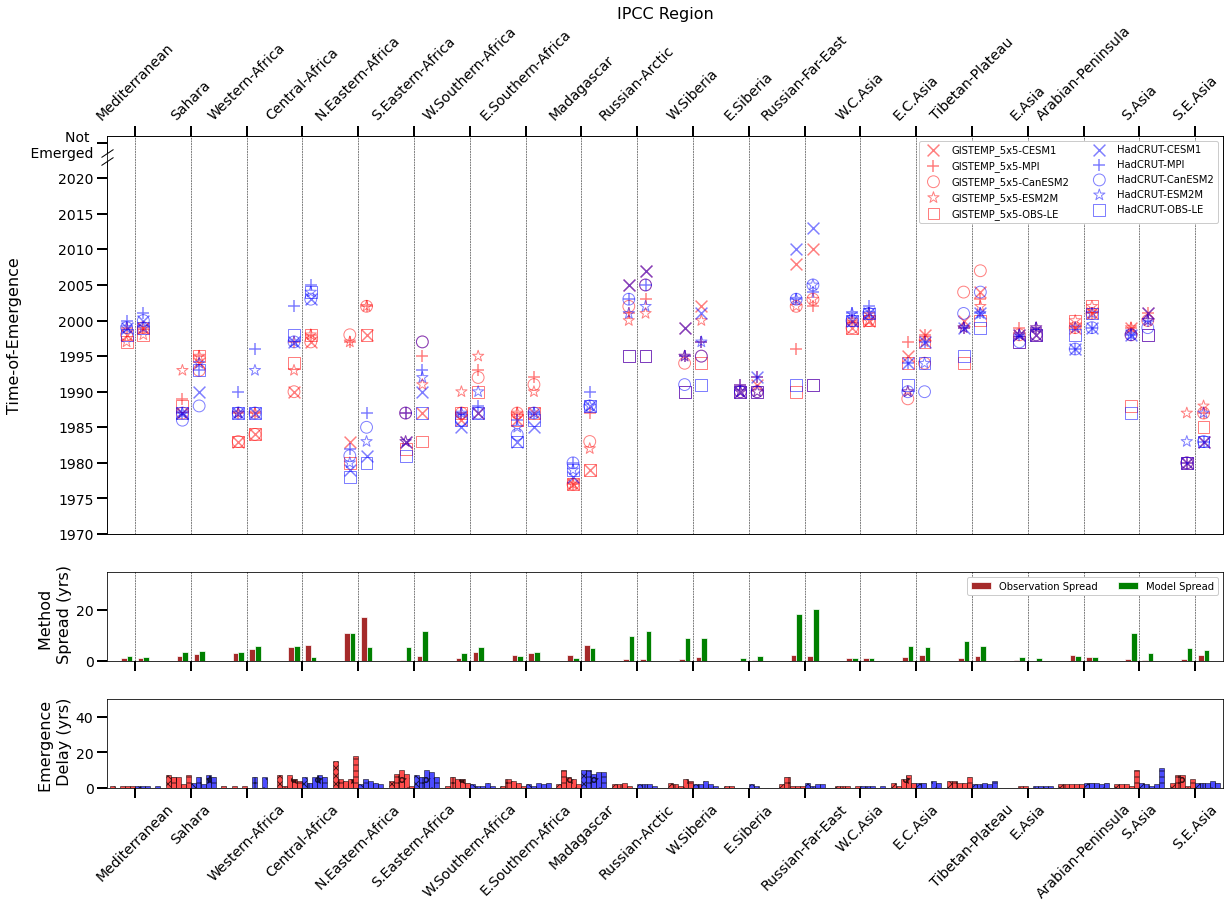

In [21]:
symbols = ['x','+','o','*','s']
hatches = ['xxx','++','o','*','--']
colors  = ['red','blue']
nan_hatch = '..' #'xx'

final_tte_ds = regional_box[0]

# Symbols that need a fill color
fill_symbols = ['x','+',]
s_value = 140
startyear = 1970

fig = plt.figure(figsize=(20,12))

gs = gridspec.GridSpec(3,1,height_ratios=[9,2,2],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1b = ax1.twiny()

start_idx = 19
stop_idx  = 38

final_tte_subset = final_tte_ds.sel(RegionIndex=slice(start_idx,stop_idx))

tick_labels = []
xstats = []

for i,(_index,_label) in enumerate(zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName)):
    xstat = i
    xstats.append(xstat)
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _mean_subset = _region_subset.sel(metric='mean')
    _strict_subset = _region_subset.sel(metric='strict')
    
    _mean_obs_spread = (_mean_subset.max(dim='obs') - _mean_subset.min(dim='obs')).mean(dim='model')#,skipna=False)
    _mean_mod_spread = (_mean_subset.max(dim='model') - _mean_subset.min(dim='model')).mean(dim='obs')
    
    _strict_obs_spread = (_strict_subset.max(dim='obs') - _strict_subset.min(dim='obs')).mean(dim='model')#,skipna=False)
    _strict_mod_spread = (_strict_subset.max(dim='model') - _strict_subset.min(dim='model')).mean(dim='obs')
    
    _delay_avg = (_strict_subset - _mean_subset).mean(dim=['obs','model'])
    _delay = _strict_subset - _mean_subset   

    ax2.bar(xstat-0.2, _mean_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
    ax2.bar(xstat-0.1, _mean_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
    ax2.bar(xstat+0.1, _strict_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)#, hatch='//')
    ax2.bar(xstat+0.2, _strict_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)#, hatch='//')
    
    # Look to hide nans
    if np.isnan(_mean_obs_spread):
        ax2.bar(xstat-0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_mean_mod_spread):
        ax2.bar(xstat-0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_strict_obs_spread):
        ax2.bar(xstat+0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_strict_mod_spread):
        ax2.bar(xstat+0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    
    # These should adapt to the number of models used to estimate PIC conditions
    space_factor = 0.9 # parameter setting the blank space between IPCC regions
    ax3_width = space_factor / (2*len(symbols))
    _offset = (0.5 - len(symbols)) * ax3_width
    
    for _obs,_color in zip(_mean_subset.obs,colors):

        _obs_subset = _mean_subset.sel(obs=_obs)

        for _model,_symbol,_hatch in zip(_obs_subset.model,symbols,hatches):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
            if (_symbol in fill_symbols):
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                
            if (np.isnan(_delay.sel(obs=_obs,model=_model))):
                ax3.bar(xstat+_offset, 50, 
                        width=ax3_width, color='white',edgecolor="black",
                        hatch=nan_hatch,linewidth=0.7)
            else:
                ax3.bar(xstat+_offset,_delay.sel(obs=_obs,model=_model),
                        width=ax3_width,color=_color,alpha=0.7,edgecolor="black",
                        hatch=_hatch,linewidth=0.7)
            
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                    
            _offset += ax3_width

    for _obs,_color in zip(_strict_subset.obs,colors):

        _obs_subset = _strict_subset.sel(obs=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            if (_symbol in fill_symbols):
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
        
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)                

# Prep legend with fake plots.
for _obs,_color in zip(_strict_subset.obs,colors):

    _obs_subset = _strict_subset.sel(obs=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        obs_str   = str(_obs.values)
        model_str = str(_model.values)
        if (_symbol in fill_symbols):
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors=_color,edgecolors=_color)
        else:
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors='none',edgecolors=_color)
        
ax2.bar(0,0, width=0.1, color='brown', edgecolor="white", linewidth=0.7, label='Observation Spread')
ax2.bar(0,0, width=0.1, color='green', edgecolor="white", linewidth=0.7, label='Model Spread')
# ax2.bar(0,0, width=0.5, color='gray',  edgecolor="black", linewidth=0.7, alpha=0.3, label='Average Delay')
        
# ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
ax1.vlines(xstats,ymin=startyear,ymax=2026,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)
ax2.vlines(xstats,ymin=0,ymax=45,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)

# Lower panel settings
# ax1.set_xlabel('IPCC Region',fontsize=16)
ax1.set_ylabel('Time-of-Emergence',fontsize=16)
# ax1.set_xticks(np.arange(1,5+1))
ax1b.set_xticks(np.arange(len(tick_labels)))
ax1.set_xticklabels(['' for i in range(len(tick_labels))],fontsize=14,rotation=45)
ax1.set_yticks(np.arange(startyear,2026,5))
ax1.set_yticklabels([str(startyear+5*i) for i in range(len(ax1.get_yticks())-1)]+['Not \n Emerged'])
# ax1.set_xlim(-0.5,4.5)
ax1.set_xlim(-0.5,len(tick_labels)-0.5)
ax1.set_ylim(startyear,2026)
ax1.tick_params(axis='x',labelsize=14,length=0,width=0)
ax1.tick_params(axis='y',labelsize=14,length=10,width=2)

# ax1b.set_xticks(np.arange(0,5))
ax1b.set_xticks(np.arange(len(tick_labels)))
ax1b.set_xticklabels(tick_labels,fontsize=14,rotation=45)
# ax1b.set_xlim(-0.5,4.5)
ax1b.set_xlim(-0.5,len(tick_labels)-0.5)
ax1b.tick_params(axis='both',labelsize=14,length=10,width=2)
ax1b.set_xlabel('IPCC Region',fontsize=16)

# Upper panel settings
ax2.set_ylabel('Method \n Spread (yrs)',fontsize=16)
# ax2.set_xticks(np.arange(0,5))
ax2.set_xticks(np.arange(len(tick_labels)))
ax2.set_xticklabels(['' for i in range(len(tick_labels))],fontsize=14,rotation=45)
# ax2.set_xticklabels(['' for i in range(5)],fontsize=14,rotation=45)
ax2.set_xlim(-0.5,len(tick_labels)-0.5)
ax2.set_ylim(0,35)
ax2.tick_params(axis='both',labelsize=14,length=10,width=2)

# Delay panel settings
ax3.set_ylabel('Emergence \n Delay (yrs)',fontsize=16)
ax3.set_xticks(np.arange(len(tick_labels)))
# ax3.set_xticks(np.arange(0,5))
# ax3.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax3.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax3.set_xlim(-0.5,len(tick_labels)-0.5)
# ax3.set_xlim(-0.5,4.5)
ax3.set_ylim(0,50)
ax3.tick_params(axis='both',labelsize=14,length=10,width=2)

# Axis breaks. I think it can't draw over the plot border because of gridspec
axis_breaky(ax1, ypos=[0.935,0.955], slant=1.5,xpos=0.0,zorder=50,w=0.01)

ax1.legend(ncol=2,loc='best',fontsize=10,facecolor='white', framealpha=1)
ax2.legend(ncol=2,loc='best',fontsize=10,facecolor='white', framealpha=1)

In [22]:
to_png(file=fig,filename='TOE_comparison2_IPCCregions_19_38',dpi=300,ext='pdf',bbox_inches='tight')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator


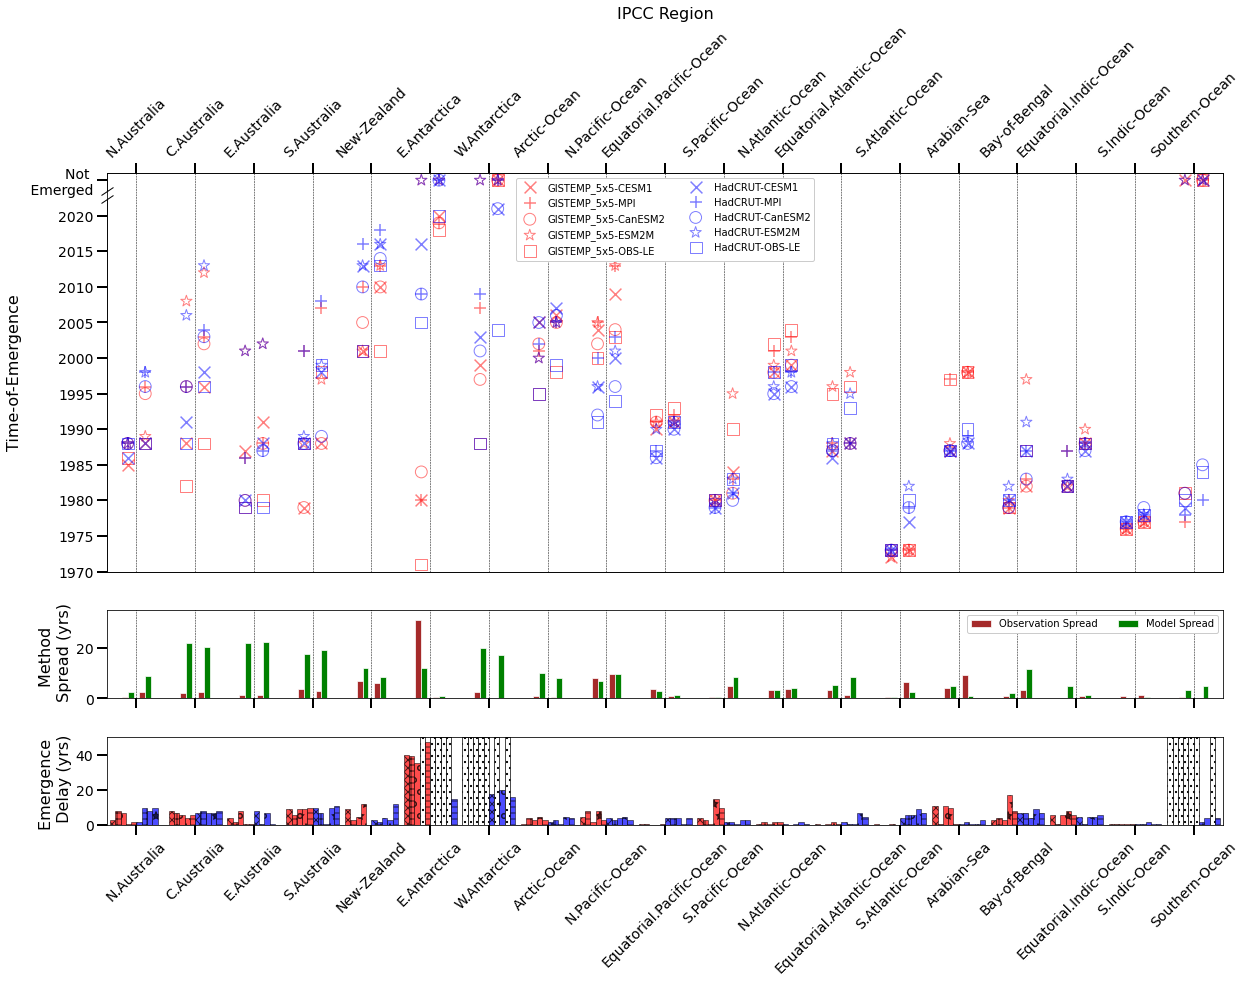

In [23]:
symbols = ['x','+','o','*','s']
hatches = ['xxx','++','o','*','--']
colors  = ['red','blue']
nan_hatch = '..' #'xx'

final_tte_ds = regional_box[0]

# Symbols that need a fill color
fill_symbols = ['x','+',]
s_value = 140
startyear = 1970

fig = plt.figure(figsize=(20,12))

gs = gridspec.GridSpec(3,1,height_ratios=[9,2,2],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1b = ax1.twiny()

start_idx = 39
stop_idx  = 57

final_tte_subset = final_tte_ds.sel(RegionIndex=slice(start_idx,stop_idx))

tick_labels = []
xstats = []

for i,(_index,_label) in enumerate(zip(final_tte_subset.RegionIndex,final_tte_subset.RegionName)):
    xstat = i
    xstats.append(xstat)
        
    _region_subset = final_tte_subset.sel(RegionIndex=_index)
    tick_labels.append(_region_subset.RegionName.values)
    
    _mean_subset = _region_subset.sel(metric='mean')
    _strict_subset = _region_subset.sel(metric='strict')
    
    _mean_obs_spread = (_mean_subset.max(dim='obs') - _mean_subset.min(dim='obs')).mean(dim='model')#,skipna=False)
    _mean_mod_spread = (_mean_subset.max(dim='model') - _mean_subset.min(dim='model')).mean(dim='obs')
    
    _strict_obs_spread = (_strict_subset.max(dim='obs') - _strict_subset.min(dim='obs')).mean(dim='model')#,skipna=False)
    _strict_mod_spread = (_strict_subset.max(dim='model') - _strict_subset.min(dim='model')).mean(dim='obs')
    
    _delay_avg = (_strict_subset - _mean_subset).mean(dim=['obs','model'])
    _delay = _strict_subset - _mean_subset   

    ax2.bar(xstat-0.2, _mean_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)
    ax2.bar(xstat-0.1, _mean_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)
    
    ax2.bar(xstat+0.1, _strict_obs_spread, width=0.1, color='brown', edgecolor="white", linewidth=0.7)#, hatch='//')
    ax2.bar(xstat+0.2, _strict_mod_spread, width=0.1, color='green', edgecolor="white", linewidth=0.7)#, hatch='//')
    
    # Look to hide nans
    if np.isnan(_mean_obs_spread):
        ax2.bar(xstat-0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_mean_mod_spread):
        ax2.bar(xstat-0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_strict_obs_spread):
        ax2.bar(xstat+0.1, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    if np.isnan(_strict_mod_spread):
        ax2.bar(xstat+0.2, 35, width=0.1, color='white', edgecolor="black", linewidth=0.7,hatch=nan_hatch)
    
    # These should adapt to the number of models used to estimate PIC conditions
    space_factor = 0.9 # parameter setting the blank space between IPCC regions
    ax3_width = space_factor / (2*len(symbols))
    _offset = (0.5 - len(symbols)) * ax3_width
    
    for _obs,_color in zip(_mean_subset.obs,colors):

        _obs_subset = _mean_subset.sel(obs=_obs)

        for _model,_symbol,_hatch in zip(_obs_subset.model,symbols,hatches):

            _model_subset = _obs_subset.sel(model=_model)

            # print('Model: ',_model.values,'. Obs: ',_obs.values,' TTE: ',_model_subset.values)
            if (_symbol in fill_symbols):
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat-0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                
            if (np.isnan(_delay.sel(obs=_obs,model=_model))):
                ax3.bar(xstat+_offset, 50, 
                        width=ax3_width, color='white',edgecolor="black",
                        hatch=nan_hatch,linewidth=0.7)
            else:
                ax3.bar(xstat+_offset,_delay.sel(obs=_obs,model=_model),
                        width=ax3_width,color=_color,alpha=0.7,edgecolor="black",
                        hatch=_hatch,linewidth=0.7)
            
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat-0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
                    
            _offset += ax3_width

    for _obs,_color in zip(_strict_subset.obs,colors):

        _obs_subset = _strict_subset.sel(obs=_obs)

        for _model,_symbol in zip(_obs_subset.model,symbols):

            _model_subset = _obs_subset.sel(model=_model)

            if (_symbol in fill_symbols):
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
            else:
                ax1.scatter(xstat+0.15,_model_subset,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)
        
            # Show markers for unemerged regions
            if np.isnan(_model_subset):
                if (_symbol in fill_symbols):
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors=_color,edgecolors=_color)
                else:
                    ax1.scatter(xstat+0.15,2025,marker=_symbol,alpha=0.5,s=s_value,facecolors='none',edgecolors=_color)                

# Prep legend with fake plots.
for _obs,_color in zip(_strict_subset.obs,colors):

    _obs_subset = _strict_subset.sel(obs=_obs)

    for _model,_symbol in zip(_obs_subset.model,symbols):

        _model_subset = _obs_subset.sel(model=_model)
        obs_str   = str(_obs.values)
        model_str = str(_model.values)
        if (_symbol in fill_symbols):
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors=_color,edgecolors=_color)
        else:
            ax1.scatter(None,None,marker=_symbol,alpha=0.5,s=s_value,label='%s-%s' % (obs_str,model_str),facecolors='none',edgecolors=_color)
        
ax2.bar(0,0, width=0.1, color='brown', edgecolor="white", linewidth=0.7, label='Observation Spread')
ax2.bar(0,0, width=0.1, color='green', edgecolor="white", linewidth=0.7, label='Model Spread')
# ax2.bar(0,0, width=0.5, color='gray',  edgecolor="black", linewidth=0.7, alpha=0.3, label='Average Delay')
        
# ax.hlines(2020,start_idx-1,stop_idx+1,colors='black',linestyle='dashed')
ax1.vlines(xstats,ymin=startyear,ymax=2026,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)
ax2.vlines(xstats,ymin=0,ymax=45,color='black',alpha=1,linestyle='dashed',linewidths=0.5,zorder=0)

# Lower panel settings
# ax1.set_xlabel('IPCC Region',fontsize=16)
ax1.set_ylabel('Time-of-Emergence',fontsize=16)
# ax1.set_xticks(np.arange(1,5+1))
ax1b.set_xticks(np.arange(len(tick_labels)))
ax1.set_xticklabels(['' for i in range(len(tick_labels))],fontsize=14,rotation=45)
ax1.set_yticks(np.arange(startyear,2026,5))
ax1.set_yticklabels([str(startyear+5*i) for i in range(len(ax1.get_yticks())-1)]+['Not \n Emerged'])
# ax1.set_xlim(-0.5,4.5)
ax1.set_xlim(-0.5,len(tick_labels)-0.5)
ax1.set_ylim(startyear,2026)
ax1.tick_params(axis='x',labelsize=14,length=0,width=0)
ax1.tick_params(axis='y',labelsize=14,length=10,width=2)

# ax1b.set_xticks(np.arange(0,5))
ax1b.set_xticks(np.arange(len(tick_labels)))
ax1b.set_xticklabels(tick_labels,fontsize=14,rotation=45)
# ax1b.set_xlim(-0.5,4.5)
ax1b.set_xlim(-0.5,len(tick_labels)-0.5)
ax1b.tick_params(axis='both',labelsize=14,length=10,width=2)
ax1b.set_xlabel('IPCC Region',fontsize=16)

# Upper panel settings
ax2.set_ylabel('Method \n Spread (yrs)',fontsize=16)
# ax2.set_xticks(np.arange(0,5))
ax2.set_xticks(np.arange(len(tick_labels)))
ax2.set_xticklabels(['' for i in range(len(tick_labels))],fontsize=14,rotation=45)
# ax2.set_xticklabels(['' for i in range(5)],fontsize=14,rotation=45)
ax2.set_xlim(-0.5,len(tick_labels)-0.5)
ax2.set_ylim(0,35)
ax2.tick_params(axis='both',labelsize=14,length=10,width=2)

# Delay panel settings
ax3.set_ylabel('Emergence \n Delay (yrs)',fontsize=16)
ax3.set_xticks(np.arange(len(tick_labels)))
# ax3.set_xticks(np.arange(0,5))
# ax3.set_xticklabels(['' for i in range(stop_idx - start_idx + 1)],fontsize=14,rotation=45)
ax3.set_xticklabels(tick_labels,fontsize=14,rotation=45)
ax3.set_xlim(-0.5,len(tick_labels)-0.5)
# ax3.set_xlim(-0.5,4.5)
ax3.set_ylim(0,50)
ax3.tick_params(axis='both',labelsize=14,length=10,width=2)

# Axis breaks. I think it can't draw over the plot border because of gridspec
axis_breaky(ax1, ypos=[0.935,0.955], slant=1.5,xpos=0.0,zorder=50,w=0.01)

ax1.legend(ncol=2,loc='best',fontsize=10,facecolor='white', framealpha=1)
ax2.legend(ncol=2,loc='best',fontsize=10,facecolor='white', framealpha=1)

In [24]:
to_png(file=fig,filename='TOE_comparison2_IPCCregions_39_57',dpi=300,ext='pdf',bbox_inches='tight')